# Imports

In [2]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, ProcessedEVLPDataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import tqdm as tqdm

# Device Setup

In [3]:
device = torch.device("mps")

# Load Data

In [4]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {8, 606}, str(val_lung_ids)
assert set(test_lung_ids) == {615, 731}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

In [4]:
len(train_dataset), len(val_dataset), len(test_dataset)

(136, 4, 6)

# Data Visualization

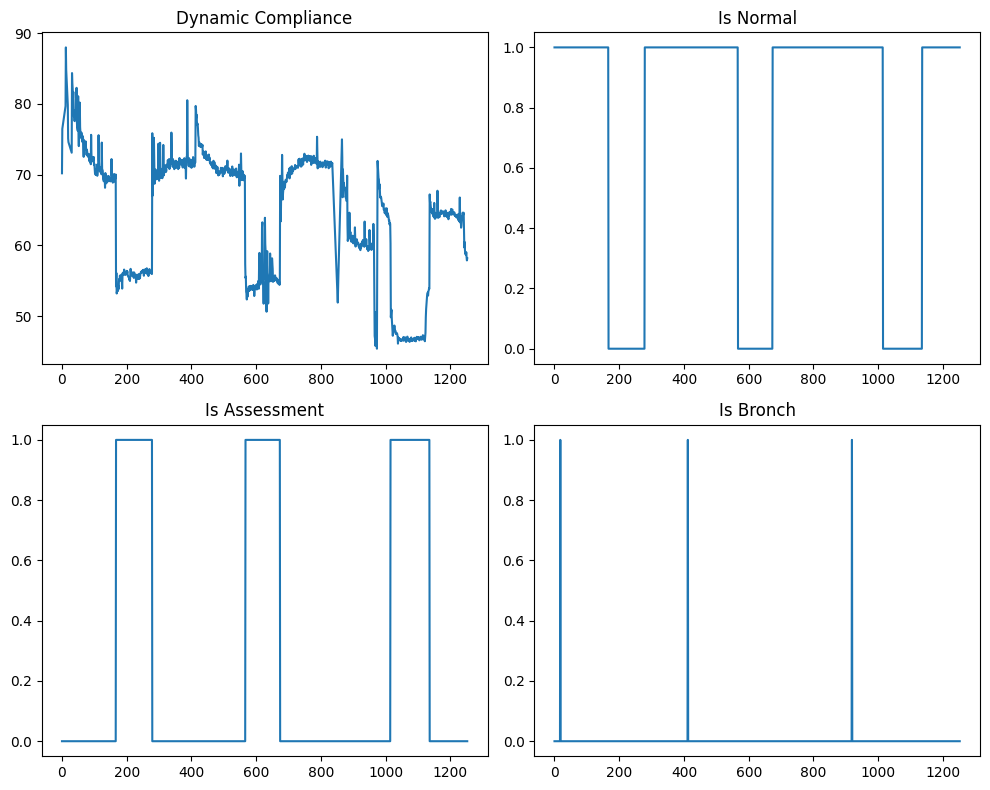

In [6]:
a = test_dataset[2]['Dy_comp']
c = test_dataset[2]['Is_normal']
b = test_dataset[2]['Is_assessment']
d = test_dataset[2]['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [7]:
def find_last(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [8]:
def right_pad_sequence(sequence, target_length):
    current_length = len(sequence)
    total_padding = target_length - current_length
    if total_padding <= 0:
        return sequence
    pad_after = total_padding

    return np.pad(sequence, (0, pad_after), mode='edge')
len(right_pad_sequence(train_dataset[0]['Dy_comp'][:1+1], 1470))
train_dataset[0]['Dy_comp'][:1+1]


array([79.11244541, 81.05219547])

In [ ]:
def create_data(dataset):
    X_dc = []
    X_is_normal = []
    X_is_bronch = []

    Y = []
    Y_len = []
    for i in train_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        # changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
        # last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

        changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

        # Find the first assessment period that starts after the last bronch occurrence
        first_assessment_after_bronch = None
        for change in changes:
            if change > metric_start + 5:
                first_assessment_after_bronch = change
                break

        if metric_start + 5 < (len(i['Is_assessment']) - 1) * 0:
            continue

        if first_assessment_after_bronch is None:
            first_assessment_after_bronch = len(i['Is_assessment']) - 1
        if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
            continue

        # 做padding，保证长度一致，用最长的长度
        X_dc.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
        X_is_normal.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
        X_is_assess.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
        X_is_bronch.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

        Y_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录长度，用于计算loss)
        Y.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))
    

# Set dataset

In [237]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []
Y_len = []

for i in train_dataset:
    metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
    # changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    # last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start + 5 < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录长度，用于计算loss)
    Y.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc)}")    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

X_dc = np.array(X_dc).reshape(-1, 1470)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470)
Y = torch.from_numpy(np.array(Y)).float()
Y_len = torch.from_numpy(np.array(Y_len)).int()

length is 108


In [238]:
X_dc_val = []
X_is_normal_val = []
X_is_bronch_val = []
X_is_assess_val = []

Y_val = []
Y_val_len = []

for i in val_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    # changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    # last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    # if metric_start < (len(i['Is_assessment']) - 1) * 0:
    #     continue

    # if metric_start > last_assessment_start: # if bronch后面没有assessment
    #     last_assessment_start = len(i['Is_assessment']) - 1
    # if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
    #     continue

    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_val.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_val.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_val.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_val.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_val_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录每个样本的长度，用于后面的pad操作
    Y_val.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc_val)}") 
assert len(X_dc_val) == len(X_is_normal_val) == len(X_is_bronch_val) == len(X_is_assess_val) == len(Y_val), "Inconsistent number of samples" 
X_dc_val = np.array(X_dc_val).reshape(-1, 1470)
X_is_normal_val = np.array(X_is_normal_val).reshape(-1, 1470)
X_is_bronch_val = np.array(X_is_bronch_val).reshape(-1, 1470)
X_is_assess_val = np.array(X_is_assess_val).reshape(-1, 1470)
Y_val = torch.from_numpy(np.array(Y_val)).float()
Y_val_len = torch.from_numpy(np.array(Y_val_len)).int()

length is 4


In [239]:
X_dc_test = []
X_is_normal_test = []
X_is_bronch_test = []
X_is_assess_test = []

Y_test = []
Y_test_len = []

for i in test_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    # changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    # last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    # if metric_start < (len(i['Is_assessment']) - 1) * 0:
    #     continue

    # if metric_start > last_assessment_start: # if bronch后面没有assessment
    #     last_assessment_start = len(i['Is_assessment']) - 1
    # if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
    #     continue

    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_test.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_test.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_test.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_test.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_test_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录每个sample的长度，用于后面的pad操作
    Y_test.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc_test)}") 
assert len(X_dc_test) == len(X_is_normal_test) == len(X_is_bronch_test) == len(X_is_assess_test) == len(Y_test), "Inconsistent number of samples" 
X_dc_test = np.array(X_dc_test).reshape(-1, 1470)
X_is_normal_test = np.array(X_is_normal_test).reshape(-1, 1470)
X_is_bronch_test = np.array(X_is_bronch_test).reshape(-1, 1470)
X_is_assess_test = np.array(X_is_assess_test).reshape(-1, 1470)
Y_test = torch.from_numpy(np.array(Y_test)).float()
Y_test_len = torch.from_numpy(np.array(Y_test_len)).int()


length is 5


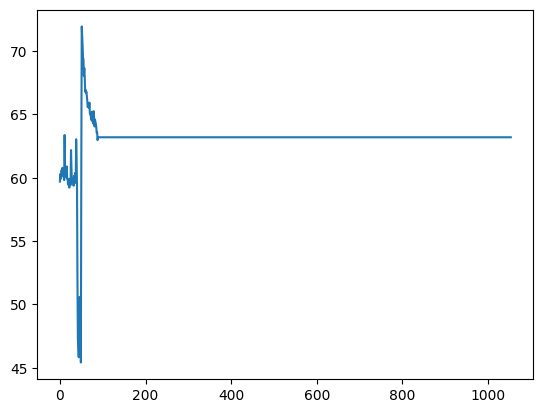

In [241]:
plt.plot(Y_test[2])

## Don't do this if not PyTorch

In [242]:
# X_dc = torch.from_numpy(X_dc).float()
# X_is_normal = torch.from_numpy(X_is_normal).float()
# X_is_assess = torch.from_numpy(X_is_assess).float()
# X_is_bronch = torch.from_numpy(X_is_bronch).float()

X_combined = np.stack([X_dc, X_is_normal, X_is_assess, X_is_bronch], axis=1)  # Shape becomes [N, 4, 1470]
X_combined = torch.from_numpy(X_combined).float()

X_combined_val = np.stack([X_dc_val, X_is_normal_val, X_is_assess_val, X_is_bronch_val], axis=1) 
X_combined_val = torch.from_numpy(X_combined_val).float()

X_combined_test = np.stack([X_dc_test, X_is_normal_test, X_is_assess_test, X_is_bronch_test], axis=1) 
X_combined_test = torch.from_numpy(X_combined_test).float()

# Tensor Flow (Abandoned)

In [13]:
# input1 = Input(shape=(1470, 1))
# cnn1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
# cnn1 = MaxPooling1D(pool_size=2)(cnn1)
# cnn1 = Flatten()(cnn1)

# input2 = Input(shape=(1470, 1))
# cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(input2)
# cnn2 = MaxPooling1D(pool_size=2)(cnn2)
# cnn2 = Flatten()(cnn2)

# merge = Concatenate()([cnn1, cnn2])
# dense = Dense(50, activation='relu')(merge)
# output = Dense(1054, activation='linear')(dense)
# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit([X_dc, X_is_normal], Y, epochs=1000, verbose=0)

# PyTorch

In [213]:
print(Y_val)

tensor([[ 73.2652, 122.8136, 122.2994,  ..., 111.0762, 111.0762, 111.0762],
        [ 44.4969,  38.7877,  39.0285,  ...,  44.3552,  44.3552,  44.3552],
        [ 39.1144,  35.6974,  35.3591,  ...,  48.0304,  48.0304,  48.0304],
        [ 40.2592,  37.5218,  36.1191,  ...,  45.7888,  45.7888,  45.7888]])


In [249]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y, Y_len):
        self.X_combined = X_combined
        self.Y = Y
        self.Y_len = Y_len

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx], self.Y_len[idx]
    
train_loader = DataLoader(EVLPDataset(X_combined, Y, Y_len), batch_size=32, shuffle=True)
val_loader = DataLoader(EVLPDataset(X_combined_val, Y_val, Y_val_len), batch_size=1, shuffle=False)
test_loader = DataLoader(EVLPDataset(X_combined_test, Y_test, Y_test_len), batch_size=1, shuffle=False)

In [244]:
for i, j, k in val_loader:
    print(i.shape, j[0], k)

torch.Size([1, 4, 1470]) tensor([119.1682, 120.8419, 120.4511,  ..., 111.0762, 111.0762, 111.0762]) tensor([303], dtype=torch.int32)
torch.Size([1, 4, 1470]) tensor([39.2334, 37.9704, 39.5915,  ..., 44.3552, 44.3552, 44.3552]) tensor([33], dtype=torch.int32)
torch.Size([1, 4, 1470]) tensor([37.5304, 38.9935, 40.4566,  ..., 48.0304, 48.0304, 48.0304]) tensor([93], dtype=torch.int32)
torch.Size([1, 4, 1470]) tensor([40.5611, 41.5025, 42.4439,  ..., 45.7888, 45.7888, 45.7888]) tensor([70], dtype=torch.int32)


In [258]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    epoch_losses = []  # List to store average training loss per epoch
    val_losses = []    # List to store average validation loss per epoch

    val_target = []
    val_predict = []

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y, lengths in train_loader:
            inputs, y = inputs.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            loss = criterion(outputs_masked, y_masked)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, y, lengths in val_loader:
                inputs, y = inputs.to(device), y.to(device)
                outputs = model(inputs)

                mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
                mask = mask.to(device)
                outputs_masked = torch.masked_select(outputs, mask).to(device)
                y_masked = torch.masked_select(y, mask).to(device)

                loss = criterion(outputs_masked, y_masked)

                val_loss = criterion(outputs_masked, y_masked)
            
                if epoch == epochs - 1:
                    val_target.append(y[:, :lengths])
                    val_predict.append(outputs[:, :lengths])
    
                running_val_loss += val_loss.item()

            average_val_loss = running_val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}")

        model.train()

    # Determine the number of rows and columns for subplots
    num_samples = len(val_predict)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(val_predict[i][0].cpu().numpy(), label='Predicted')
        plt.plot(val_target[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', color='red', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model.eval()

    output_ls = []
    target_ls = []

    test_loss = 0
    with torch.no_grad():
        for data, y, lengths in test_loader:
            data, y = data.to(device), y.to(device)
            outputs = model(data)
            
            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            loss = criterion(outputs_masked, y_masked)
            output_ls.append(outputs[:, :lengths])
            target_ls.append(y[:, :lengths])

            case_loss = criterion(outputs_masked, y_masked).item()
            test_loss += case_loss

    test_loss /= len(test_loader.dataset)

    # Determine the number of rows and columns for subplots
    num_samples = len(output_ls)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(output_ls[i][0].cpu().numpy(), label='Predicted')
        plt.plot(target_ls[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Test set: Average loss: {test_loss:.4f}')

In [259]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.fc_seq = torch.nn.Sequential( 
            torch.nn.Linear(46848, 128),
            torch.nn.ReLU()
        )
        self.final_layer = nn.Linear(in_features=128, out_features=1054)

    def forward(self, x):
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        x = self.final_layer(x)
        return x

## Performance Comparison

Epoch 10, Training Loss: 461.46730041503906, Validation Loss: 384.5619885921478
Epoch 20, Training Loss: 467.05820083618164, Validation Loss: 331.36780297756195
Epoch 30, Training Loss: 287.7937660217285, Validation Loss: 261.28611183166504
Epoch 40, Training Loss: 337.76091384887695, Validation Loss: 277.66536045074463
Epoch 50, Training Loss: 270.2529411315918, Validation Loss: 277.538161277771
Epoch 60, Training Loss: 397.32150650024414, Validation Loss: 279.9621824026108
Epoch 70, Training Loss: 300.3661575317383, Validation Loss: 258.6208219528198
Epoch 80, Training Loss: 379.08656311035156, Validation Loss: 425.9869728088379
Epoch 90, Training Loss: 300.9273910522461, Validation Loss: 241.04220485687256
Epoch 100, Training Loss: 469.383113861084, Validation Loss: 280.4904842376709


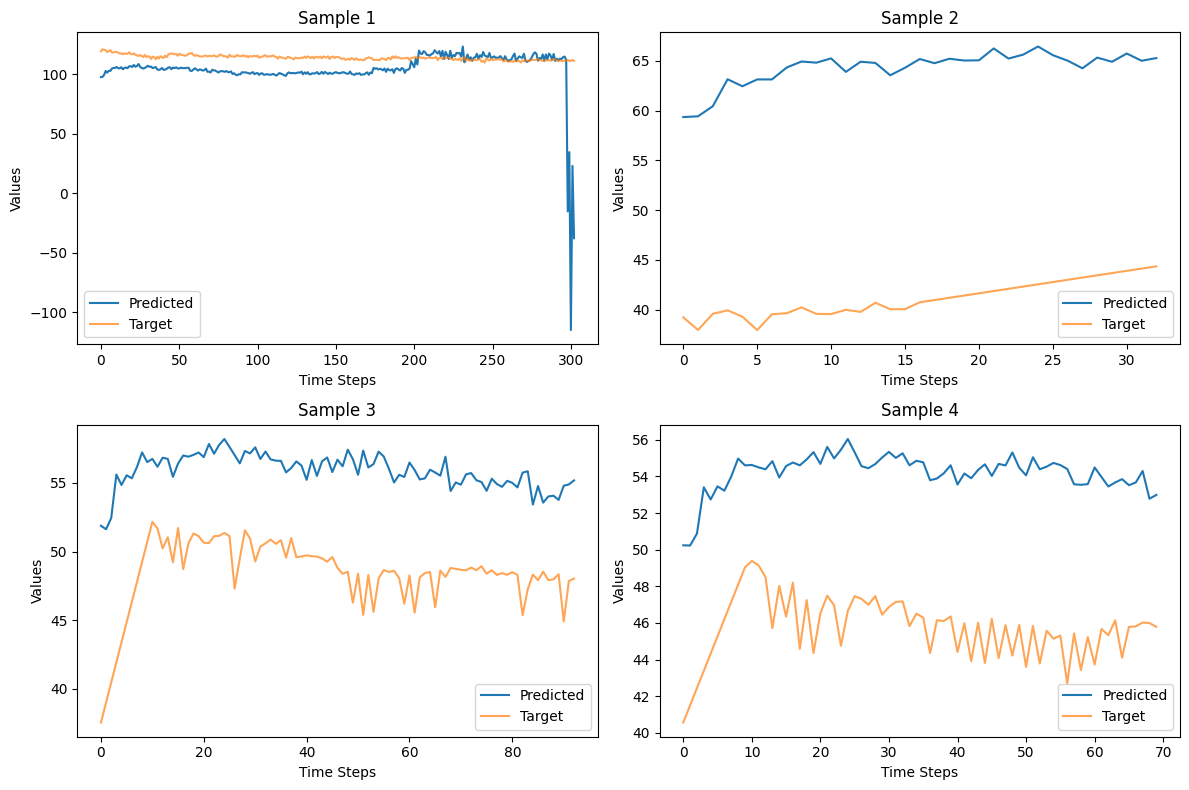

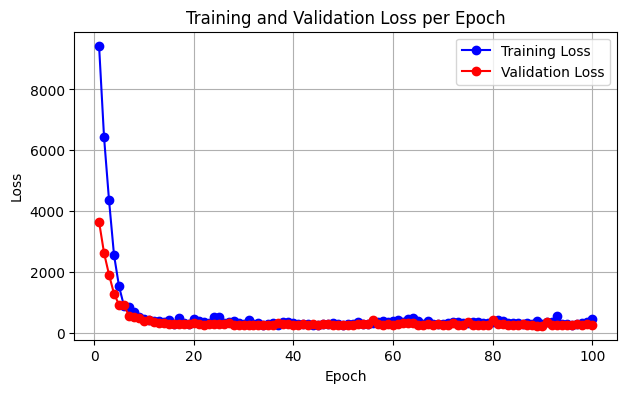

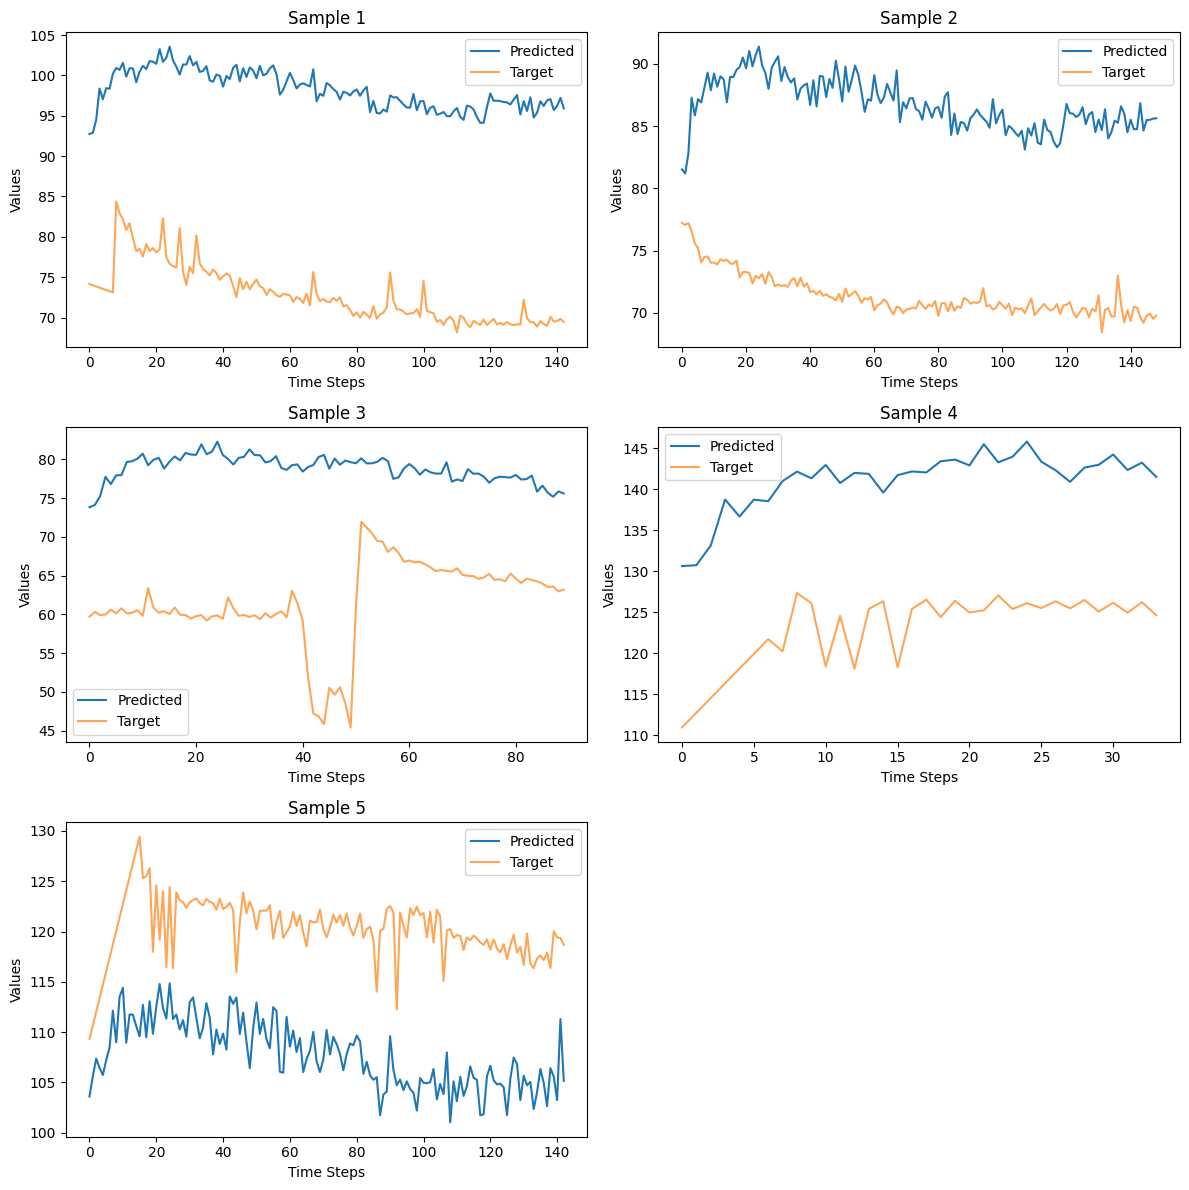

Test set: Average loss: 344.6021


In [260]:
epochs = 100
model = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

Epoch 10, Training Loss: 735.0057220458984, Validation Loss: 427.6503937244415
Epoch 20, Training Loss: 337.1313285827637, Validation Loss: 258.4550975561142
Epoch 30, Training Loss: 288.15070152282715, Validation Loss: 258.80853366851807
Epoch 40, Training Loss: 372.74380111694336, Validation Loss: 251.5244917869568
Epoch 50, Training Loss: 387.2242431640625, Validation Loss: 315.5242614746094
Epoch 60, Training Loss: 319.7344055175781, Validation Loss: 273.44366550445557
Epoch 70, Training Loss: 405.1612014770508, Validation Loss: 282.38580417633057
Epoch 80, Training Loss: 283.2642135620117, Validation Loss: 297.1127166748047
Epoch 90, Training Loss: 368.6024742126465, Validation Loss: 248.32945704460144
Epoch 100, Training Loss: 347.23611068725586, Validation Loss: 334.02624130249023
Epoch 110, Training Loss: 308.7607078552246, Validation Loss: 316.11564445495605
Epoch 120, Training Loss: 338.60449981689453, Validation Loss: 246.18455266952515
Epoch 130, Training Loss: 310.12697982

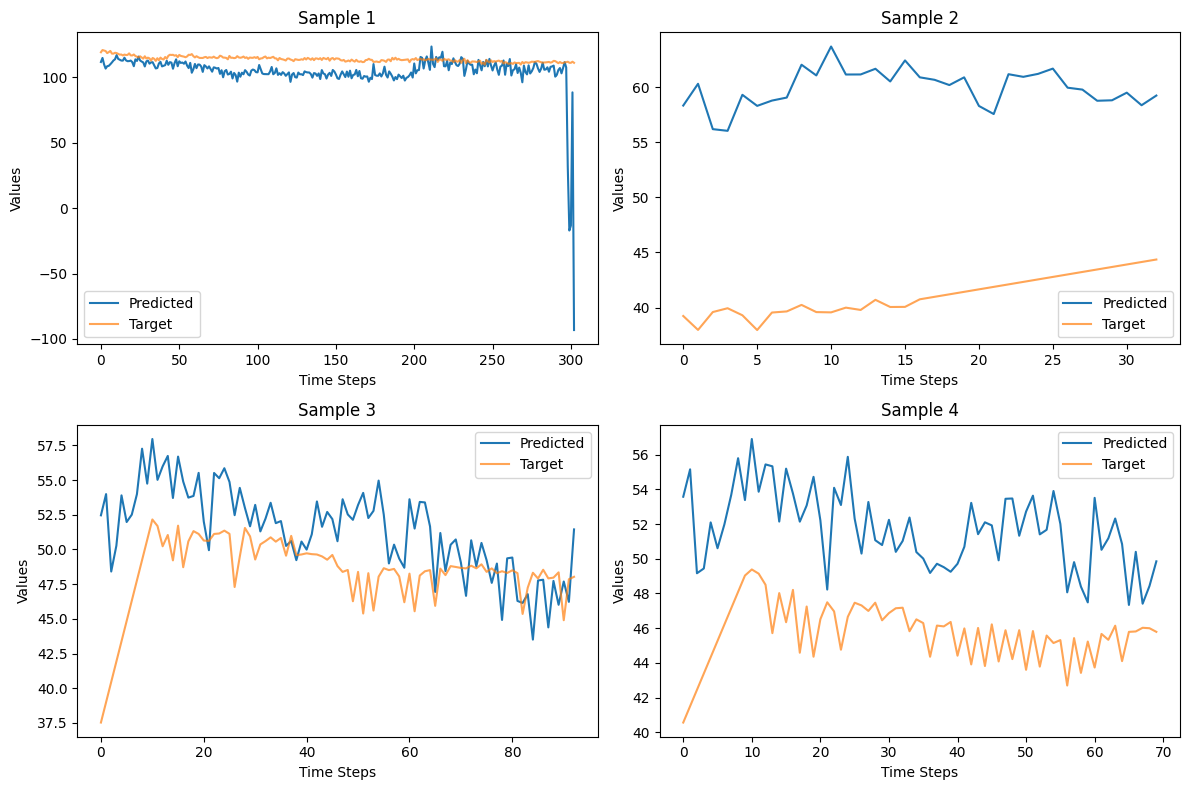

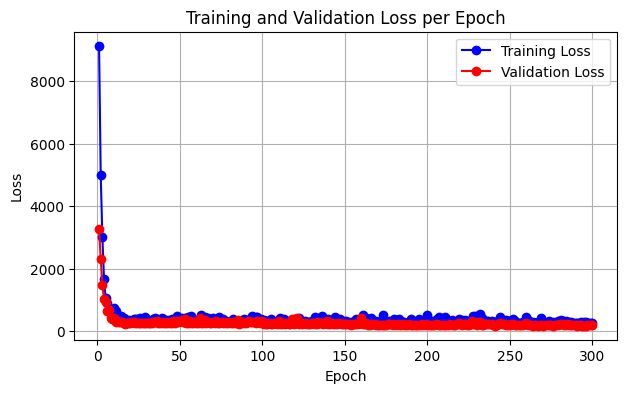

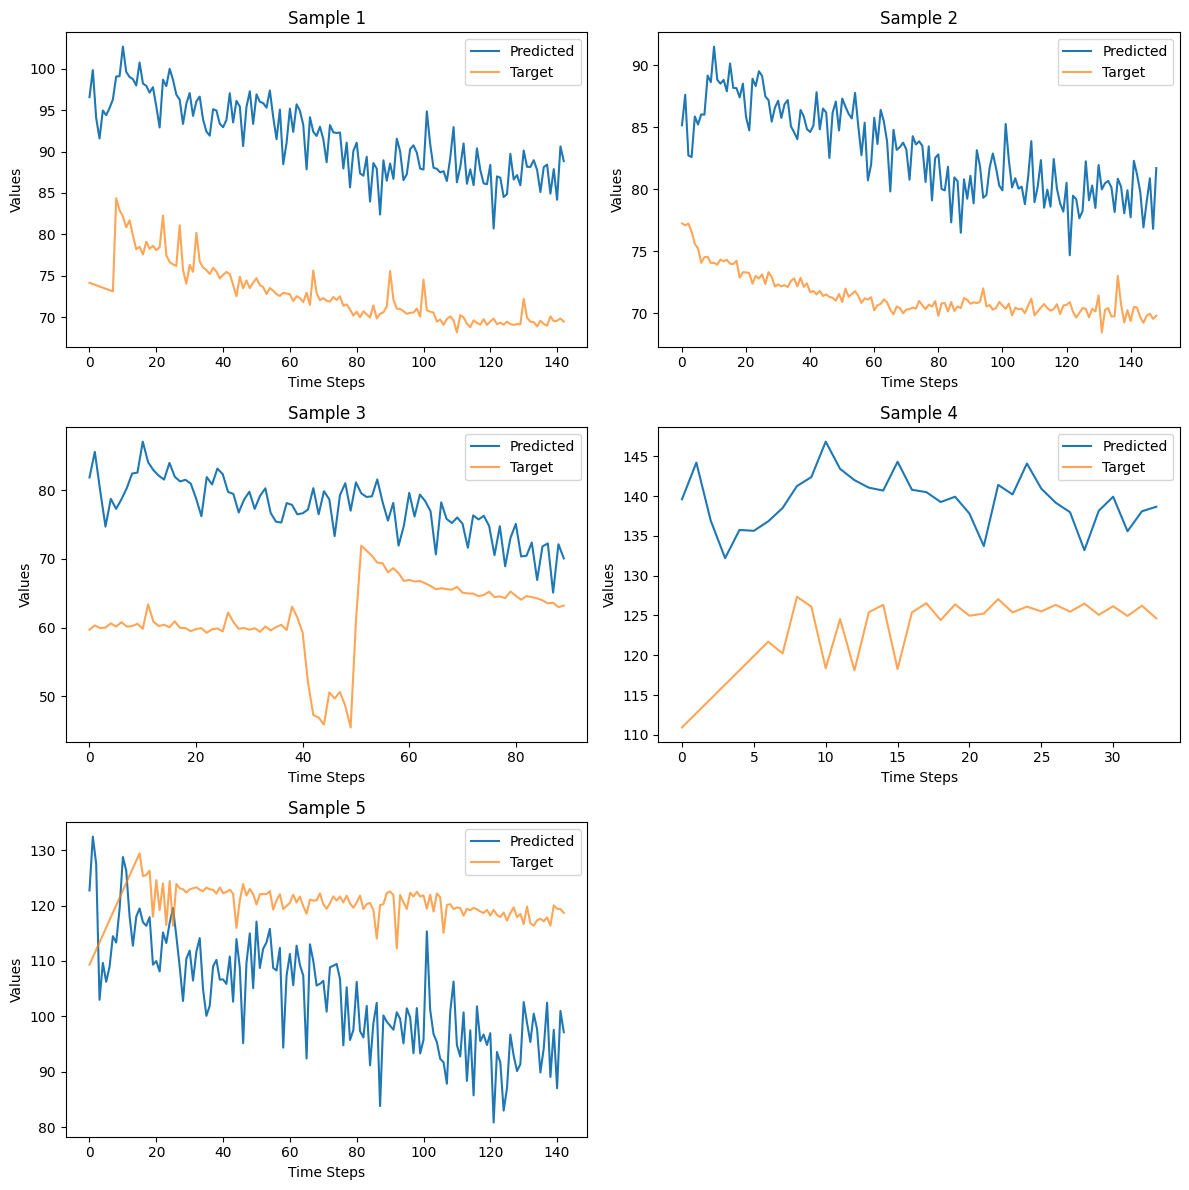

Test set: Average loss: 296.2969


In [261]:
epochs = 300
model = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

# CSTM

In [19]:
class CNNLSTM(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0, lstm_hidden_size=128, lstm_layers=1):
        super().__init__()

        self.conv1 = nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # LSTM layer
        self.lstm = nn.LSTM(input_size=46848, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)

        # Final fully connected layer
        self.final_layer = nn.Linear(in_features=lstm_hidden_size, out_features=1054)

    # 
    def forward(self, x):
        # CNN layers
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)  # Adding a sequence dimension
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.final_layer(x)
        return x

Epoch 100, Training Loss: 857.0726623535156, Validation Loss: 1484.8040771484375


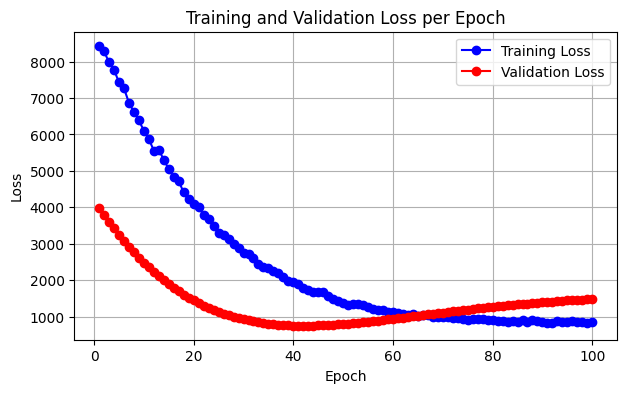

Test set: Average loss: 112.8794


In [20]:
model1 = CNNLSTM(kernel=3, num_filters=64, num_in_channels=4, lstm_hidden_size=128, lstm_layers=1).to(device)
epochs = 100
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, amsgrad=True)
criterion = nn.MSELoss()

train(model1, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

# SOCNN
Source: https://arxiv.org/pdf/1703.04122.pdf

## Issue Summary
Offset has dimension [32, time_step (1470), 1054] and x has dimension [32, 4, 1470]. X needs to have the same shape as offset in order to do addition.

In [31]:
# Define the Offset Network (Multilayer Perceptron)
class OffsetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OffsetNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc1.weight.data.uniform_(0, 0.005)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        return x

# Define the Significance Network (Fully Convolutional Network)
class SignificanceNetwork(nn.Module):
    def __init__(self, channels):
        super(SignificanceNetwork, self).__init__()
        self.conv1 = nn.Conv1d(channels, 1054, kernel_size=14, dilation=113)
        self.conv1.weight.data.uniform_(0, 0.005)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x))
        return x

# Define the SOCNN Model
class SOCNN(nn.Module):
    def __init__(self, input_dim, output_dim, time_steps, channels):
        super(SOCNN, self).__init__()
        self.time_steps = time_steps
        self.output_dim = output_dim
    
        self.significance_network = SignificanceNetwork(channels).to(device)
        self.offset_network = OffsetNetwork(input_dim, output_dim).to(device)

    def forward(self, x):
        batch_size = x.shape[0] # shape = [32, 4, 1470]
        self.W = nn.Parameter(torch.empty((batch_size, self.output_dim, self.time_steps)).uniform_(0, 0.005)).to(device)

        significance = self.significance_network(x) # shape = 32, 1054, 1]

        offsets = torch.stack([self.offset_network(x[:, :, i]) for i in range(self.time_steps)])
        offsets = torch.reshape(offsets, (offsets.shape[1], offsets.shape[0], offsets.shape[2])) # shape = [32, time_step (1470), 1054]
        
        test = torch.bmm(self.W, offsets) # shape = [32, 1054, 1054])
        y_hat = torch.bmm(test, significance) # shape = [32, 1054, 1]
        y_hat = torch.reshape(y_hat, (y_hat.shape[0], y_hat.shape[2], y_hat.shape[1]))
        return y_hat

Epoch 100, Training Loss: 960.2035675048828, Validation Loss: 925.60205078125
Epoch 200, Training Loss: 914.9347686767578, Validation Loss: 909.8885498046875


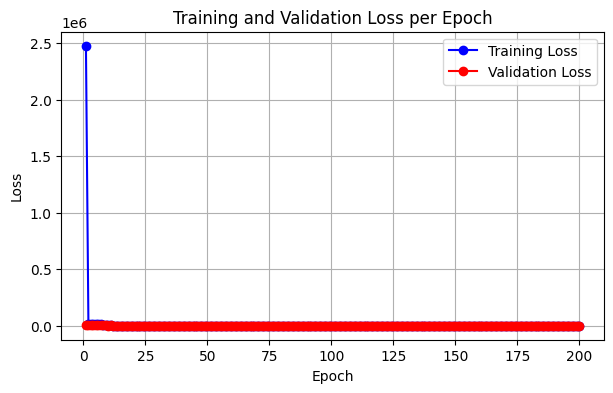

Test set: Average loss: 203.0476


In [32]:
model2 = SOCNN(input_dim=4, output_dim=1054, time_steps=1470, channels=4).to(device)

epochs = 200
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, amsgrad=True)
criterion = nn.MSELoss() 

train(model2, train_loader, val_loader, test_loader, criterion, optimizer, epochs)